# Value Estimation Methods

We will use the ['Frozen Lake' environment in 'Gymnasium'](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) to provide examples of value estimation.

### 1. Environment Analysis

> The game starts with the player at location $[0,0]$ of the frozen lake grid world with the goal located at far extent of the world e.g. $[3,3]$ for the $4 \times 4$ environment. Holes in the ice are distributed in set locations when using a pre-determined map or in random locations when a random map is generated. The player makes moves until they reach the goal or fall in a hole.

**Observation space**: for a $4 \times 4$ map, $\mathcal{S} = \{s \in \mathbb{Z} ∣ 0 \leq s \leq 15\}$. If the agent is in the $i$-th row and $j$-th column ($i, j \in \{0, 1, 2, 3\}$) at timestep $t$, then $s_t = 4i+j$.

**Action space**: $a \in \{0, 1, 2, 3\}$, indicating which direction to move the agent. $0$: move left, $1$: move down, $2$: move right, $3$: move up.

**Initial state**: the episode starts with the agent in state $0$ (the $0$-th row and $0$-th column), i.e. $s_0 = 0$.

**Termination of an episode**: 
- Case 1: The agent moves into a hole.
- Case 2: The agent reaches the goal.
- Case 3: (Truncation) The length of the current episode has reached its maximum value ($100$).

**Reward**: reach goal: $+1$, reach hole: $0$, reach frozen: $0$.

observation dimension = 16
action dimension = 4
initial state = 0


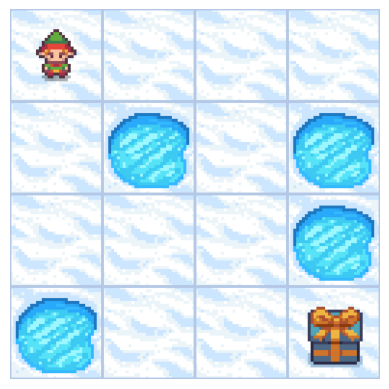

In [1]:
from env.frozen_lake_env import FrozenLakeEnv

env = FrozenLakeEnv()
print('observation dimension = {}'.format(env.observation_dim))
print('action dimension = {}'.format(env.action_dim))

init_state = env.reset()
print('initial state = {}'.format(init_state))
env.render()

current state = 4


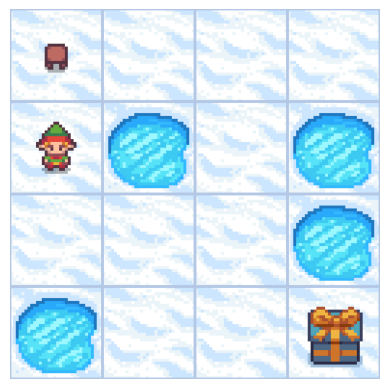

In [2]:
action = 1 # move down
obs, reward, done, info = env.step(action)
print('current state = {}'.format(obs))
env.render()

### 2. Monte-Carlo Methods

#### 2.1 How to sample trajectories?

~~~python
    def run_episode(self):
        traj = []
        obs = self.env.reset()
        while True:
            action = np.random.choice(np.arange(self.env.action_dim), p=self.policy[obs])
            next_obs, reward, done, info = self.env.step(action)
            traj.append((obs, action, reward))
            obs = next_obs

            if done:
                break

        return traj
~~~

#### 2.2 How to update state values?

~~~python
    def update_state_values(self, traj):
        G = 0
        visited_states = set()
        for t in reversed(range(len(traj))):
            obs, action, reward = traj[t]
            G = reward + self.gamma * G
            if obs not in visited_states:
                self.returns_sum[obs] += G
                self.returns_count[obs] += 1
                self.values_table[obs] = self.returns_sum[obs] / self.returns_count[obs]
                visited_states.add(obs)

~~~

#### 2.3 Let's play the MC method on the frozen lake environment.

In [3]:
from alg.monte_carlo import MonteCarloStateValueEstimator

num_episode = 10000
record_inverval = 20
record_state_idx = 14
record_list = []

mc_value_estimator = MonteCarloStateValueEstimator(env)

for episode_idx in range(num_episode):
    traj = mc_value_estimator.run_episode()
    mc_value_estimator.update_state_values(traj)
    if episode_idx % record_inverval == 0:
        record_list.append(mc_value_estimator.values_table[record_state_idx])

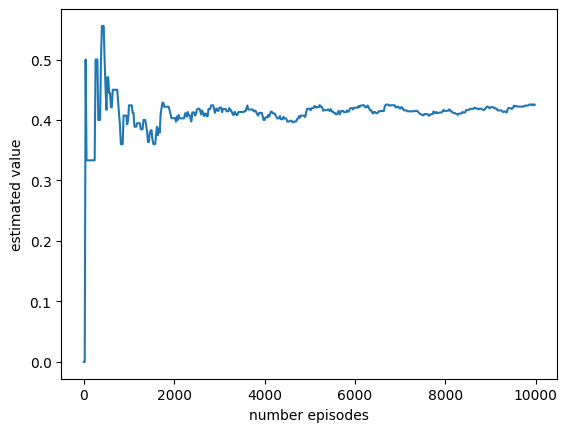

In [4]:
import matplotlib.pyplot as plt

episode_idx_list = list(range(0, num_episode, record_inverval))

plt.plot(episode_idx_list, record_list)
plt.xlabel('number episodes')
plt.ylabel('estimated value')
plt.show()


In [5]:
for value in mc_value_estimator.sorted_values_table:
    print(value)

(0, 0.0145)
(1, 0.011567285760834147)
(2, 0.019310867095797046)
(3, 0.011945392491467578)
(4, 0.017449238578680203)
(6, 0.038202247191011236)
(8, 0.039149888143176735)
(9, 0.09411764705882353)
(10, 0.15007215007215008)
(13, 0.18543046357615894)
(14, 0.4252199413489736)


### 3. Temporal Difference Methods

**Recall:**

- **TD target:** $r_{t+1} + \gamma \tilde{V}_\pi({s}_{t+1})$
- **TD error:** $r_{t+1} + \gamma \tilde{V}_\pi({s}_{t+1}) - V_\pi ({s}_t)$
- **TD update rule:** $V_\pi^{[m+1]}({s}_t) \leftarrow V_\pi^{[m]}({s}_t) + \alpha \left(r_{t+1}^{[m+1]} + \gamma \tilde{V}_\pi({s}_{t+1}) - V_\pi^{[m]}({s}_t)\right)$, where $\alpha = \frac{1}{m+1}$, and $m$ indicates the number of times state ${s}_t$ has been visited.

~~~python
    def update_state_values(self, traj):
        for t in reversed(range(len(traj))):
            obs, action, reward, next_obs = traj[t]
            TD_target = reward + self.gamma * self.values_table[next_obs]
            TD_error = TD_target - self.values_table[obs]
            
            self.states_count[obs] += 1
            alpha = 1 / (self.states_count[obs] + 1)
            self.values_table[obs] += alpha * TD_error
~~~

In [6]:
from alg.temporal_difference import TdStateValueEstimator

num_episode = 10000

td_value_estimator = TdStateValueEstimator(env)

for episode_idx in range(num_episode):
    traj = td_value_estimator.run_episode()
    td_value_estimator.update_state_values(traj)

In [7]:
for value in td_value_estimator.sorted_values_table:
    print(value)

(0, 0.009545012474731251)
(1, 0.010185242049589786)
(2, 0.020253246383574713)
(3, 0.012116123470276434)
(4, 0.011800019241026707)
(5, 0.0)
(6, 0.03820843034088388)
(7, 0.0)
(8, 0.031374087918209025)
(9, 0.08773334334989534)
(10, 0.14334134612991944)
(11, 0.0)
(12, 0.0)
(13, 0.18553219824167244)
(14, 0.4602069552893806)
(15, 0.0)
